In [41]:
import pandas as pd
import numpy as np
import os
import scipy.stats as spstats
import statsmodels.api as sm
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
import altair as alt
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

# Functions

In [39]:
def check_dir(dir: str):
    """
    Creates a given path directory if it does not exist.

    Args:
        dir (str): Path to the directory to be created.
    """
    if os.path.exists(dir) and os.path.isdir(dir):
        pass
    else:
        os.makedirs(dir)


def dint_filter(results, alpha=0.05):
    """
    Filters results from dint_searcher function based on statistical significance and signal consistency.

    Args:
        results (pd.DataFrame): DataFrame containing correlation and regression analysis results.
        alpha (float, optional): Significance level for statistical tests. Defaults to 0.05.

    Returns:
        pd.DataFrame: Filtered results meeting the following criteria:
            - Both correlation and OLS p-values below alpha
            - Correlation and OLS coefficients have the same sign
            - Either tumour-normal p-values >= alpha OR different signal than tumour coefficient
    """
    # Both correlation and OLS p-values have to be lower than 0.05
    rhosign = results.rho_pval < alpha
    coefsign = results.coef_pval < alpha

    # Correlation and OLS have to have the same signal
    equalsignal = (results.rho/results.rho.abs()) == (results.coef/results.coef.abs())

    # Tumour-normal p-values have to be higher or equal to alfa or signal has to be different than tumour
    coefdiffnotsign = results.coef_diff_pval >= alpha
    distinctsign = (results.coef/results.coef.abs()) != (results.coef_diff/results.coef_diff.abs())

    return results[rhosign & coefsign & equalsignal & (coefdiffnotsign | distinctsign)].reset_index(drop=True)


def driver_neighbour_corr(
    driver: int,
    neighbourlist: list,
    mutationtab: np.array,
    expressiontab: np.array,
    ctfilter: np.array = None
) -> tuple:
    """
    Calculates Spearman correlation between a driver mutation and its neighbouring genes' expression.

    Parameters:
        driver (int): Index of the driver gene in the mutation table.
        neighbourlist (list): List of indices for neighbouring genes.
        mutationtab (np.array): 2D array of shape (n_samples, n_drivers) containing mutation data.
        expressiontab (np.array): 2D array of shape (n_samples, n_neighbours) containing expression data.
        ctfilter (np.array, optional): Boolean array of shape (n_drivers, n_samples) for filtering samples.
            Defaults to None, in which case all samples are used.

    Returns:
        tuple: Two elements:
            - rho: Array of correlation coefficients
            - pvalue: Array of corresponding p-values
    """
    if ctfilter is not None:
        filt = ctfilter[driver]
    else:
        filt = [True]*len(mutationtab)

    rho, pvalue = spstats.spearmanr(
        expressiontab[np.ix_(filt, neighbourlist)],
        mutationtab[filt, driver]
    )

    if len(neighbourlist) > 1:
        return rho[-1, :-1], pvalue[-1, :-1]
    else:
        return [rho], [pvalue]


def ols(y, X, resname):
    """
    Performs Ordinary Least Squares regression and returns coefficient and p-value for a specific variable.

    Args:
        y (array-like): Dependent variable.
        X (array-like): Independent variables (including constant term if needed).
        resname (str or int): Name/position of the variable whose coefficient is of interest.

    Returns:
        dict: Dictionary containing:
            - coef: Coefficient estimate for the specified variable
            - coef_pval: P-value for the coefficient
    """
    result = sm.OLS(y, X).fit()
    return {"coef": result.params[resname], "coef_pval": result.pvalues[resname]}


def driver_neighbour_ols(
    driver: int,
    neighbourlist: list,
    regressorstab: np.array,
    expressiontab: np.array,
    regressorsfilter: np.array = None,
    driverpos: int = 0,
    n_jobs: int = 1
):
    """
    Performs parallel OLS regression analysis between a driver mutation and its neighbouring genes' expression.

    Parameters:
        driver (int): Index of the driver gene.
        neighbourlist (list): List of indices for neighbouring genes.
        regressorstab (np.array): 2D array of shape (n_samples, n_regressors) containing predictor variables.
        expressiontab (np.array): 2D array of shape (n_samples, n_neighbours) containing expression data.
        regressorsfilter (np.array, optional): Boolean 2D array of shape (n_drivers, n_regressors) for filtering regressors.
        driverpos (int, optional): Position of the driver variable in the regressors table. Defaults to 0.
        n_jobs (int, optional): Number of parallel jobs to run. Defaults to 1.

    Returns:
        list: List of dictionaries containing regression results for each neighbour, including:
            - coef: Coefficient estimate
            - coef_pval: P-value for the coefficient
    """
    if regressorsfilter is not None:
        regfilt = regressorsfilter[driver]
        sampfilt = np.flatnonzero(regressorstab[:, regfilt].sum(axis=1)>1)
    else:
        regfilt = [True]*regressorstab.shape[1]
        sampfilt = [True]*regressorstab.shape[0]
        
    ols_list = Parallel(n_jobs=n_jobs)(delayed(ols)(
        expressiontab[sampfilt, neighbour],
        regressorstab[np.ix_(sampfilt, regfilt)],
        driverpos) for neighbour in neighbourlist)

    return ols_list


def dint_searcher(
    neighbourtab: pd.DataFrame,
    mutationtab: pd.DataFrame,
    tumourexp: pd.DataFrame,
    normalexp: pd.DataFrame,
    savetofile: str = False,
    filterdints: bool = False,
    alpha: float = 0.05,
    shuffle: np.random.Generator = False,
    progressbar: bool = False,
    n_jobs: int = 1
):
    """
    Searches for driver-neighbour interactions (DINTs) by analyzing relationships
    between driver mutations and neighbouring gene expression.

    Parameters:
        neighbourtab (pd.DataFrame): Boolean matrix indicating neighbourhood relationships between genes.
        mutationtab (pd.DataFrame): Matrix of mutation data with MultiIndex (patient, cancer_type).
        tumourexp (pd.DataFrame): Matrix of tumour expression data.
        normalexp (pd.DataFrame): Matrix of normal tissue expression data.
        savetofile (str, optional): Path to save results. If False, returns results instead. Defaults to False.
        filterdints (bool, optional): Whether to filter results using dint_filter. Defaults to False.
        alpha (float, optional): Significance level for statistical tests. Defaults to 0.05.
        shuffle (np.random.Generator, optional): Random number generator for permutation testing. Defaults to False.
        progressbar (bool, optional): Whether to show progress bar. Defaults to False.
        n_jobs (int, optional): Number of parallel jobs for OLS analysis. Defaults to 1.

    Returns:
        pd.DataFrame or None: If savetofile is False, returns DataFrame containing:
            - rho: Spearman correlation coefficient
            - rho_pval: Correlation p-value
            - driver: Driver gene identifier
            - neighbour: Neighbour gene identifier
            - coef: OLS coefficient
            - coef_pval: OLS p-value
            - coef_diff: Tumour-normal difference coefficient
            - coef_diff_pval: Tumour-normal difference p-value
        If savetofile is True, saves results to file and returns None.
    """
    if shuffle:
        # For correlation and tumour OLS, shuffle is made on cancer type
        mutationtab_ = mutationtab.copy()
        mutationtab_.index = pd.MultiIndex.from_tuples(
            shuffle.permutation(mutationtab.index), names=["patient", "cancer_type"])
    else:
        mutationtab_ = mutationtab.copy()

    # ------------------------- Preprocessing ------------------------------- #
    # correlation preprocessing
    # filter by cancer type
    # Since these filters will be index by driver, we will transpose the arrays
    # to simplify indexing
    ctfilter = mutationtab_.groupby("cancer_type").agg(lambda x: x.sum() > 0).T.to_numpy()
    ctfilterdiff = (
        mutationtab.loc[normalexp.index.get_level_values("patient")]
            .groupby("cancer_type").agg(lambda x: x.sum() > 0)
    ).T.to_numpy()

    # Calculate mean for spearman correlation analysis
    tumourexpmean = tumourexp.groupby("cancer_type").mean().to_numpy()
    mutationtabmean = mutationtab_.groupby("cancer_type").mean().to_numpy()

    # OLS preprocessing
    # Create cancer type dummy regressors for OLS analysis
    regressors = pd.get_dummies(mutationtab_.reset_index(level=1), dtype=int, drop_first=False)
    
    # diff will be shuffled in the end
    regressorsdiff = pd.get_dummies(
        mutationtab.loc[normalexp.index.get_level_values("patient")].reset_index(level=1),
            dtype=int, drop_first=False)
    
    # add constant column
    regressors = sm.add_constant(regressors, prepend=False).to_numpy()
    regressorsdiff = sm.add_constant(regressorsdiff, prepend=False).to_numpy()
    
    # create regressorsfilter to filter cancer_types and drivers in regressors array
    regressors_filter = np.concatenate([
        np.identity(mutationtab.shape[1]).astype(bool), # to choose Driver Mutation Profile
        np.concatenate([
            ctfilter, # choose only cancer types with at least one mutated patient
            np.ones((ctfilter.shape[0], 1)) # choose constant column for all drivers
        ], axis=1).astype(bool), ], axis=1)
    
    regressorsdiff_filter = np.concatenate([
        np.identity(mutationtab.shape[1]).astype(bool),
        np.concatenate([ctfilterdiff, np.ones((ctfilterdiff.shape[0], 1))], axis=1).astype(bool),
        ], axis=1)

    # calculate tumour - normal expression
    tumournormaldiff = (tumourexp.loc[normalexp.index] - normalexp).to_numpy()
    tumourexparr = tumourexp.to_numpy()

    if shuffle:
        # for diff OLS, shuffle is made on expression
        shuffle.shuffle(tumournormaldiff)
        
    # -------------------------- DINT analysis -------------------------------#
    neighbourlist = [(driver, np.flatnonzero(neighbourtab[driver])) for driver in neighbourtab.columns.tolist()]
    
    corr_results = {col: [] for col in ["rho", "rho_pval", "driver", "neighbour"]}
    ols_results = []
    olsdiff_results = []

    if progressbar:
        neighbourlist = tqdm(neighbourlist)
    else:
        neighbourlist = neighbourlist

    for i, (driver, neighbours) in enumerate(neighbourlist):

        rho, pval = driver_neighbour_corr(i, neighbours, mutationtabmean,
                                          tumourexpmean, ctfilter=ctfilter)
        corr_results["rho"].extend(rho)
        corr_results["rho_pval"].extend(pval)
        corr_results["driver"].extend([driver]*len(neighbours))
        corr_results["neighbour"].extend(neighbours)

        ols_list = driver_neighbour_ols(i, neighbours, regressors, tumourexparr,
                                        regressorsfilter=regressors_filter, driverpos=0, n_jobs=n_jobs)
        ols_results.extend(ols_list)

        ols_list = driver_neighbour_ols(i, neighbours, regressorsdiff, tumournormaldiff,
                                        regressorsfilter=regressorsdiff_filter, driverpos=0, n_jobs=n_jobs)

        olsdiff_results.extend(ols_list)

    # ------------------------------ Result Filtering ------------------------------#
    results = pd.merge(
        pd.DataFrame(corr_results).set_index("neighbour"),
        pd.Series(neighbourtab.index).rename("neighbour"), left_index=True, right_index=True
    ).reset_index(drop=True)

    results = pd.concat([results, pd.DataFrame(ols_results), pd.DataFrame(olsdiff_results).rename(columns={
        "coef": "coef_diff",
        "coef_pval": "coef_diff_pval"
    })], axis=1)

    if filterdints:
        results = dint_filter(results.dropna(), alpha=alpha)

    if savetofile:
        results.to_csv(savetofile, index=False)
    else:
        return results
    
def drivergroups(x):
    """
    Categorize a driver based on its interaction patterns with neighbours.
    
    Parameters:
        x (pd.Series): Series containing counts of interactions with columns:
            - n_dints: total number of interactions
            - neg_dints: number of negative interactions
            - pos_dints: number of positive interactions
    
    Returns:
        str: Category label for the driver:
            - 'non_sign': No significant interactions
            - 'pos': Only positive interactions
            - 'neg': Only negative interactions
            - 'more_neg': More negative than positive interactions
            - 'more_pos': More positive than negative interactions
            - 'neutral': Equal number of positive and negative interactions
    """
    if x.n_dints == 0:
        return "non_sign"
    else:
        if x.neg_dints == 0:
            return "pos"
        elif x.pos_dints == 0:
            return "neg"
        else:
            if x.neg_dints > x.pos_dints:
                return "more_neg"
            elif x.pos_dints > x.neg_dints:
                return "more_pos"
            else:
                return "neutral"


def labeldrivers(
    df: pd.DataFrame,
    output=None
):
    """
    Recursively label all drivers in a DataFrame based on their interaction patterns.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing driver interaction data
        output (list, optional): List to store labels during recursive calls. Defaults to None.
    
    Returns:
        list: List of labels for each driver in the DataFrame, categorized according to
              the drivergroups function criteria
    
    Notes:
        - This function uses recursion to process each row of the DataFrame
        - Each driver is labeled based on its positive and negative interaction counts
    """
    if output is None:
        output = []

    if len(output) == len(df):
        return output
    else:
        x = df.iloc[len(output)]
        return labeldrivers(df, output=output+[drivergroups(x)])


def labelneighbours(df):
    """
    Label all neighbours in a DataFrame based on their interaction patterns.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing neighbour interaction data with columns:
            - n_dints: total number of interactions
            - neg_dints: number of negative interactions
            - pos_dints: number of positive interactions
    
    Returns:
        list: List of labels for each neighbour:
            - 'non_sign': No significant interactions
            - 'pos': Only positive interactions
            - 'neg': Only negative interactions
            - 'neutral': Both positive and negative interactions
    
    Notes:
        - Unlike drivers, neighbours are only categorized as neutral if they have
          both positive and negative interactions, regardless of which is more numerous
    """
    labels = []
    for i in range(len(df)):
        x = df.iloc[i]
        if x.n_dints == 0:
            labels.append("non_sign")
        else:
            if x.neg_dints == 0:
                labels.append("pos")
            elif x.pos_dints == 0:
                labels.append("neg")
            else:
                labels.append("neutral")
    return labels

def count_significant_interactions(df):
    """
    Count the number of statistically significant interactions in a DataFrame, categorizing them as positive or negative.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing interaction data with columns 'rho_pval', 'coef_pval', and 'rho'
    
    Returns:
        tuple: A tuple containing three integers:
            - Total number of significant interactions (both rho_pval and coef_pval < 0.05)
            - Number of significant positive interactions (rho > 0)
            - Number of significant negative interactions (rho < 0)
    """
    significant = df[(df['rho_pval'] < 0.05) & (df['coef_pval'] < 0.05)]
    positive = significant[significant['rho'] > 0]
    negative = significant[significant['rho'] < 0]
    return len(significant), len(positive), len(negative)

## Visualization functions

In [54]:
def create_spearman_plot(driver, neighbour_gene, mutationtab, tumourexp):
    """
    Create a scatter plot showing the correlation between driver gene mutation frequency and neighbour gene expression across cancer types.
    
    Parameters:
        driver (str): Name of the driver gene to analyze mutations
        neighbour_gene (str): Name of the neighbouring gene to analyze expression
        mutationtab (pd.DataFrame): DataFrame containing mutation data with cancer types as index and genes as columns
        tumourexp (pd.DataFrame): DataFrame containing tumour expression data with cancer types as index and genes as columns
    
    Returns:
        None: Displays a scatter plot with:
            - X-axis: Mean expression of neighbour gene
            - Y-axis: Mean mutation frequency of driver gene
            - Points colored by cancer type
            - Annotation showing Spearman's correlation coefficient (ρ) and p-value
    
    Notes:
        - Only includes cancer types with at least one mutation in the driver gene
        - Points represent cancer type averages
        - P-value is displayed in scientific notation
        - Legend is positioned below the plot with multiple columns
    """
    # Filter by cancer_type that has at least one mutation in the driver
    mutationtab_filtered = mutationtab.groupby('cancer_type').filter(lambda x: x[driver].sum() > 0)
    tumourexp_filtered = tumourexp.loc[mutationtab_filtered.index]

    # Obtain the averages of mutations and expression per type of cancer
    grouped_data_mut = mutationtab_filtered.groupby('cancer_type')[driver].mean()
    grouped_data_exp = tumourexp_filtered.groupby('cancer_type')[neighbour_gene].mean()
    grouped_data = pd.DataFrame({
        'mean_mutation': grouped_data_mut,
        'mean_expression': grouped_data_exp
    }).reset_index()

    # Calculate Spearman's correlation
    correlation, p_value = spearmanr(grouped_data['mean_expression'], grouped_data['mean_mutation'])

    # Format the p-value as an exact value, in scientific notation
    p_value_annotation = f"P = {p_value:.2e}"  # Always displays the exact p-value in scientific notation

    # Plot the data
    plt.figure(figsize=(12, 8))
    sns.set(font_scale=1.2)

    sns.scatterplot(x='mean_expression', y='mean_mutation', data=grouped_data, hue='cancer_type', s=100)
    #plt.title(f'Expression of {neighbour_gene} vs. Mutation Frequency in {driver}', fontsize=20)
    plt.xlabel(f'Mean Expression of {neighbour_gene}', fontsize=18)
    plt.ylabel(f'Mean Mutation Frequency in {driver}', fontsize=18)

    plt.legend(title='Cancer Type', bbox_to_anchor=(0, -0.15), loc='upper left', ncol=7)

    # Add annotation with the correct format of ρ and exact p-value
    plt.annotate(f"Spearman's ρ = {correlation:.2f}\n{p_value_annotation}", 
                 xy=(0.05, 0.95),  # top left corner
                 xycoords='axes fraction', 
                 ha='left', 
                 va='top', 
                 fontsize=16, 
                 bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='gray', lw=1))

    plt.tight_layout()
    plt.show()

def create_ols_boxplots(driver, neighbour_gene, coef, p_value, mutationtab, tumourexp):
    """
    Create boxplots comparing neighbour gene expression between mutated and non-mutated samples for each cancer type.
    
    Parameters:
        driver (str): Name of the driver gene to analyze mutations
        neighbour_gene (str): Name of the neighbouring gene to analyze expression
        coef (float): Coefficient from OLS regression to display in annotation
        p_value (float): P-value from OLS regression to display in annotation
        mutationtab (pd.DataFrame): DataFrame containing mutation data with cancer types in index
        tumourexp (pd.DataFrame): DataFrame containing tumour expression data
    
    Returns:
        None: Displays boxplots with:
            - X-axis: Cancer types
            - Y-axis: Expression of neighbour gene
            - Boxes colored by mutation status (No/Yes)
            - Annotation showing coefficient and p-value
            
    Notes:
        - Creates paired boxplots for each cancer type
        - Blue boxes represent non-mutated samples, orange boxes represent mutated samples
        - P-value is displayed in scientific notation
        - Legend is positioned to the right of the plot
    """
    # Check that the driver and neighbour_gene columns are in the DataFrames
    if driver not in mutationtab.columns or neighbour_gene not in tumourexp.columns:
        print(f"Error: {driver} or {neighbour_gene} not found in the data.")
        return
    
    # Extract the mutation status column of the driver gene and the expression of the neighbouring gene
    mutation_status = mutationtab[driver]
    gene_expression = tumourexp[neighbour_gene]
    
    # Create a DataFrame combining expression, mutation status and cancer type
    combined_data = pd.DataFrame({
        'cancer_type': mutationtab.index.get_level_values('cancer_type'),
        'expression': gene_expression,
        'mutated': mutation_status
    })

    # Plot the data
    fig, ax = plt.subplots(figsize=(12, 8))
    colors = ['#1f77b4', '#ff7f0e']
    
    sns.boxplot(x='cancer_type', y='expression', hue='mutated', data=combined_data, palette=colors, fliersize=2, ax=ax)
    
    # Removing the title
    # ax.set_title(f'{neighbour_gene} Expression vs {driver} Mutation Status by Cancer Type', fontsize=20)

    ax.set_xlabel('Cancer Type', fontsize=18)
    ax.set_ylabel(f'{neighbour_gene} Expression', fontsize=18)
    plt.xticks(rotation=45, ha='right')
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, ['No', 'Yes'], title='Mutated', loc='upper left', bbox_to_anchor=(1, 1), fontsize=16)
    
    plt.tight_layout()
    fig.subplots_adjust(top=0.85)
    
    # Add the annotation with the coefficient and p-value provided
    ax.annotate(f'Coef = {coef:.2f}\nP = {p_value:.2e}', 
                xy=(0.98, 0.98), 
                xycoords='axes fraction',
                ha='right', 
                va='top', 
                fontsize=16, 
                bbox=dict(boxstyle='round', fc='white', ec='gray'))
    
    plt.show()

def create_ols_boxplots_tumour_normal(driver, neighbour_gene, coef, p_value, mutationtab, tumourexp, normalexp):
    """
    Create boxplots comparing tumour-normal expression differences between mutated and non-mutated samples for each cancer type.
    
    Parameters:
        driver (str): Name of the driver gene to analyze mutations
        neighbour_gene (str): Name of the neighbouring gene to analyze expression
        coef (float): Coefficient from OLS regression to display in annotation
        p_value (float): P-value from OLS regression to display in annotation
        mutationtab (pd.DataFrame): DataFrame containing mutation data with cancer types in index
        tumourexp (pd.DataFrame): DataFrame containing tumour expression data
        normalexp (pd.DataFrame): DataFrame containing normal tissue expression data
    
    Returns:
        None: Displays boxplots with:
            - X-axis: Cancer types
            - Y-axis: Tumour-Normal expression difference of neighbour gene
            - Boxes colored by mutation status (No/Yes)
            - Annotation showing coefficient and p-value
    
    Notes:
        - Expression difference is calculated as tumour expression minus normal expression
        - Creates paired boxplots for each cancer type
        - Blue boxes represent non-mutated samples, orange boxes represent mutated samples
        - P-value is displayed in scientific notation
        - Legend is positioned to the right of the plot
    """
    # Check that the driver and neighbour_gene columns are in the DataFrames
    if driver not in mutationtab.columns or neighbour_gene not in tumourexp.columns or neighbour_gene not in normalexp.columns:
        print(f"Error: {driver} or {neighbour_gene} not found in the data.")
        return
    
    # Extract the driver gene mutation status column and calculate the tumour-normal expression difference
    mutation_status = mutationtab[driver]
    tumournormaldiff = tumourexp[neighbour_gene] - normalexp[neighbour_gene]
    
    # Create a DataFrame combining expression difference, mutation status, and cancer type
    combined_data = pd.DataFrame({
        'cancer_type': mutationtab.index.get_level_values('cancer_type'),
        'expression_diff': tumournormaldiff,
        'mutated': mutation_status
    })
    
    # Plot the data
    fig, ax = plt.subplots(figsize=(12, 8))
    colors = ['#1f77b4', '#ff7f0e']
    
    sns.boxplot(x='cancer_type', y='expression_diff', hue='mutated', data=combined_data, palette=colors, fliersize=2, ax=ax)
    
    #ax.set_title(f'{neighbour_gene} Tumour-Normal Expression Difference vs {driver} Mutation Status by Cancer Type', fontsize=20)
    ax.set_xlabel('Cancer Type', fontsize=18)
    ax.set_ylabel(f'{neighbour_gene} Tumour-Normal Expression Difference', fontsize=18)
    plt.xticks(rotation=45, ha='right')
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, ['No', 'Yes'], title='Mutated', loc='upper left', bbox_to_anchor=(1, 1), fontsize=16)
    
    plt.tight_layout()
    fig.subplots_adjust(top=0.85)
    
    # Add the annotation with the coefficient and p-value provided
    ax.annotate(f'Coef = {coef:.2f}\nP = {p_value:.2e}', 
                xy=(0.98, 0.98), 
                xycoords='axes fraction',
                ha='right', 
                va='top', 
                fontsize=16, 
                bbox=dict(boxstyle='round', fc='white', ec='gray'))
    
    plt.show()

def autopct_format(values):
    """
    Creates a formatter function for displaying both absolute values and percentages in matplotlib pie charts.
    
    Parameters:
        values (list): A list of numerical values that sum to the total of the pie chart
    
    Returns:
        function: A formatter function that takes a percentage and returns a string with both
                 the absolute value and percentage in the format 'value\n(percentage%)'
    
    Examples:
        >>> values = [75, 25]
        >>> formatter = autopct_format(values)
        >>> formatter(25.0)
        '25\n(25.0%)'
        
    Notes:
        - The returned formatter function is intended to be used with matplotlib's pie chart
          autopct parameter
        - The formatter rounds absolute values to integers and displays percentages with
          one decimal place
    """
    def my_format(pct):
        total = sum(values)
        val = int(round(pct * total / 100.0))
        return f'{val}\n({pct:.1f}%)' 
    return my_format

# Directories

In [4]:
datadir = "data/"
shuffledir = datadir + "shuffle/"
check_dir(datadir)
check_dir(shuffledir)

In [5]:
networks = ["biogrid", "apid", "huri", "string", "omnipath"]

# Driver Neighbour analysis

## Load Datasets

In [6]:
mutationtab = pd.read_feather(datadir+"mutation.feather")
print(mutationtab.shape)
display(mutationtab.head(2))
neighbourtab = pd.read_feather(datadir+"neighbours.feather")
print(neighbourtab.shape)
display(neighbourtab.head(2))

(8404, 2570)


,,A1CF,A2ML1,ABCA10,ABCA13,ABCA7,ABCB1,ABCB5,ABCC3,ABCC5,ABCC9,...,ZPBP2,ZRANB3,ZRSR2,ZSCAN31,ZSCAN4,ZSWIM3,ZSWIM6,ZWILCH,ZWINT,ZZEF1
patient,cancer_type,,,,,,,,,,,,,,,,,,,,,
TCGA-02-0047,GBM,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-02-0055,GBM,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(15206, 2570)


driver,A1CF,A2ML1,ABCA10,ABCA13,ABCA7,ABCB1,ABCB5,ABCC3,ABCC5,ABCC9,...,ZPBP2,ZRANB3,ZRSR2,ZSCAN31,ZSCAN4,ZSWIM3,ZSWIM6,ZWILCH,ZWINT,ZZEF1
neighbour,,,,,,,,,,,,,,,,,,,,,
A1BG,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
A1CF,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [7]:
tumourexp = pd.read_feather(datadir+"tumour_expression.feather")
print(tumourexp.shape)
display(tumourexp.head(2))
normalexp = pd.read_feather(datadir+"normal_expression.feather")
print(normalexp.shape)
display(normalexp.head(2))

(8404, 15206)


,,A1BG,A1CF,A2M,A2ML1,A4GALT,A4GNT,AAAS,AACS,AADAT,AAGAB,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
patient,cancer_type,,,,,,,,,,,,,,,,,,,,,
TCGA-02-0047,GBM,6.98,0.0,15.05,5.40,5.22,1.16,8.87,8.92,7.87,10.01,...,8.03,8.66,6.05,8.48,10.12,0.69,10.24,11.92,10.45,9.24
TCGA-02-0055,GBM,8.62,0.0,15.39,1.42,8.93,0.64,9.22,8.31,6.66,10.41,...,8.87,7.95,5.45,8.14,9.25,2.60,9.85,13.49,9.25,9.49


(665, 15206)


,,A1BG,A1CF,A2M,A2ML1,A4GALT,A4GNT,AAAS,AACS,AADAT,AAGAB,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
patient,cancer_type,,,,,,,,,,,,,,,,,,,,,
TCGA-22-4593,LUSC,5.66,0.0,17.08,0.00,8.60,1.62,9.13,9.96,7.28,9.97,...,7.60,7.19,5.22,8.32,9.63,0.83,9.89,12.92,10.51,8.83
TCGA-22-4609,LUSC,6.12,0.0,16.80,2.28,8.59,0.76,8.83,9.60,6.89,9.41,...,7.29,5.59,6.04,9.02,10.24,1.03,9.87,12.66,11.12,9.19


In [8]:
tumourexp.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 8404 entries, ('TCGA-02-0047', 'GBM') to ('TCGA-ZX-AA5X', 'CESC')
Columns: 15206 entries, A1BG to ZZZ3
dtypes: float64(15206)
memory usage: 975.3+ MB


## DINT Search

In [14]:
results = dint_searcher(
        neighbourtab, mutationtab, tumourexp, normalexp, savetofile=False,
        filterdints=False, shuffle=False, progressbar=True, n_jobs=-1
    )
results.to_csv(datadir+"results.csv", index=False)
results.head()

  0%|          | 0/2570 [00:00<?, ?it/s]

,rho,rho_pval,driver,neighbour,coef,coef_pval,coef_diff,coef_diff_pval
0,-0.242212,0.317756,A1CF,APOB,-0.307001,0.117268,-1.013937,0.355157
1,0.159719,0.513660,A1CF,APOBEC1,NaN,NaN,0.394227,0.398841
2,-0.018429,0.940308,A1CF,APOBEC2,0.094182,0.501902,0.413046,0.495099
3,0.258886,0.284517,A1CF,APOBEC3A,-0.043689,0.779266,-0.015337,0.981601
4,0.365950,0.123349,A1CF,APOBEC3B,0.041200,0.785462,0.535376,0.393236


## Shuffle

To assess the robustness of the identified DINTs and estimate the False Discovery Rate (FDR), we conducted permutation tests with random shuffling of the gene expression data. The shuffling helped to determine if the observed patterns were likely due to chance. We used 100 permutations, each generating a set of DINTs by randomising the neighbour gene expression data. The average number of significant DINTs identified in the shuffled datasets was compared to the number identified in the original dataset.

In [13]:
from random import getrandbits
seed = getrandbits(128)
print(seed)
rng = np.random.default_rng(seed)

309814212404889481310444358379219863528


In [14]:
for i, stream in enumerate(tqdm(rng.spawn(100))):

    dint_searcher(
        neighbourtab, mutationtab, tumourexp, normalexp, savetofile=shuffledir+f"shuffle{i+1}.csv",
        filterdints=True, alpha=0.05, shuffle=stream, progressbar=False, n_jobs=-1
    )

  0%|          | 0/100 [00:00<?, ?it/s]

/home/rnasysbiolab1/miniconda3/envs/jamiranda/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/rnasysbiolab1/miniconda3/envs/jamiranda/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


# Shuffle Results

In [6]:
dints = pd.read_csv(datadir+"DINTs.csv", usecols=["driver", "neighbour"])
dints.head(2)

,driver,neighbour
0,A2ML1,BAK1
1,A2ML1,CEP152


The FDR analysis revealed that, when using a significance threshold of 0.05, approximately 36.97% of the identified significant interactions could be false positives. 

In [7]:
rand_dist = [len(pd.read_csv(shuffledir+shuffle)) for shuffle in os.listdir(shuffledir)]
print(np.mean(rand_dist)/len(dints))

0.3696640135239839


In [8]:
common_dist = []
for shuffle in os.listdir(shuffledir):
    x = pd.read_csv(shuffledir+shuffle, usecols=["driver", "neighbour"])
    common_dist.append(x.merge(dints).shape[0]/x.shape[0])

common_dist = pd.DataFrame(common_dist, columns=["pct"])

In [9]:
(alt
 .Chart(common_dist, width=800, height=200, title="Percentage of DINTs found in Shuffled")
 .mark_boxplot(size=50, ticks=True)
 .encode(alt.X("pct:Q").axis(format='%'))
)

alt.Chart(...)

## New filter

To produce a list of DINTs with higher statistical confidence, we lowered the significance threshold to 0.001. This adjustment refined the list to 813 DINTs effectively reducing the FDR to below 10% (0.0846).

In [15]:
alpha = 0.001
dints = pd.read_csv(datadir+"DINTs.csv")
newdints = dint_filter(dints, alpha=alpha)
print(len(newdints))

newrand_dist = [len(dint_filter(pd.read_csv(shuffledir+shuffle), alpha=alpha)) for shuffle in os.listdir(shuffledir)]

print(np.mean(newrand_dist)/len(newdints))

813
0.08460024600246002


In [16]:
newdints.to_csv(datadir+"DINTs0.001.csv", index=False)

In [17]:
alpha = 0.001
dints = dint_filter(pd.read_csv(datadir+"results_mac.csv"))
newdints_mac = dint_filter(dints, alpha=alpha)
print(len(newdints))

newrand_dist = [len(dint_filter(pd.read_csv(shuffledir+shuffle), alpha=alpha)) for shuffle in os.listdir(shuffledir)]

print(np.mean(newrand_dist)/len(newdints_mac))

813
0.08428921568627451


In [18]:
newdints[["driver", "neighbour"]].merge(newdints_mac[["driver", "neighbour"]], how="inner")

,driver,neighbour
0,AFF3,TTF2
1,AHI1,LYAR
2,AHNAK,EFTUD2
3,AKAP9,CEP55
4,AKAP9,TUB
...,...,...
790,ZMYM3,MTA2
791,ZNF217,EZH2
792,ZNF536,CENPA
793,ZNF668,ZNF512


# DINT Results

In [32]:
results = pd.read_csv(datadir+"results.csv")
results.head()

,rho,rho_pval,driver,neighbour,coef,coef_pval,coef_diff,coef_diff_pval
0,-0.242212,0.317756,A1CF,APOB,-0.307001,0.117268,-1.013937,0.355157
1,0.159719,0.513660,A1CF,APOBEC1,NaN,NaN,0.394227,0.398841
2,-0.018429,0.940308,A1CF,APOBEC2,0.094182,0.501902,0.413046,0.495099
3,0.258886,0.284517,A1CF,APOBEC3A,-0.043689,0.779266,-0.015337,0.981601
4,0.365950,0.123349,A1CF,APOBEC3B,0.041200,0.785462,0.535376,0.393236


In [33]:
print("# of interactions in maingraph:", len(results))
print("# of drivers in maingraph:", results.driver.nunique())
print("# of neighbours in maingraph:", results.neighbour.nunique())
results.dropna(inplace=True)
print("# of interactions with results:", len(results))
print("# of drivers with results:", results.driver.nunique())
print("# of neighbours with results:", results.neighbour.nunique())

# of interactions in maingraph: 383337
# of drivers in maingraph: 2570
# of neighbours in maingraph: 15206
# of interactions with results: 361705
# of drivers with results: 2565
# of neighbours with results: 13064


We filtered the results based on several criteria. First, both the correlation and OLS p-values had to be less than 0.05. Additionally, the correlation and OLS signals (i.e., whether they were positive or negative) needed to be consistent. Finally, for tumour versus normal comparisons, the p-values had to be greater than or equal to 0.05, or the OLS coefficient signal had to differ from that observed in the previous analyses with tumour-only samples.

In [34]:
resultsfiltered = dint_filter(results).set_index(["driver", "neighbour"]).reset_index()
resultsfiltered.to_csv(datadir+"DINTs.csv", index=False)
resultsfiltered.head()

,driver,neighbour,rho,rho_pval,coef,coef_pval,coef_diff,coef_diff_pval
0,A2ML1,BAK1,0.616355,0.001340,0.099646,0.035045,-0.025126,0.910538
1,A2ML1,CEP152,0.446281,0.028816,0.233134,0.000372,0.161886,0.546178
2,A2ML1,DOT1L,0.441061,0.030974,0.171850,0.000543,0.139439,0.557473
3,A2ML1,SRRT,0.550239,0.005338,0.084226,0.005848,-0.069655,0.634963
4,A2ML1,ST6GALNAC6,-0.561549,0.004299,-0.135210,0.007368,0.238886,0.367315


After implementing these stringent criteria, the number of interactions under consideration was reduced from 361705 to 14197, representing only the significant DINTs.

In [35]:
print(resultsfiltered.driver.unique().shape[0])
print(resultsfiltered.neighbour.unique().shape[0])
print(len(resultsfiltered))

1655
3120
14197


## Analysis between cancer types 

In [36]:
# Sort the DataFrame by the value of the 'rho_pval' column from smallest to largest
sorted_combined_results = resultsfiltered.sort_values(by='rho_pval', ascending=True)
print(sorted_combined_results)

        driver neighbour       rho      rho_pval      coef     coef_pval  \
5398     FBXW7     SNRPF  0.896104  3.953026e-08  0.114823  1.160621e-03   
658        APC    RNF146 -0.836386  5.518993e-08 -0.069335  7.244011e-03   
1519     BRCA1      TUBB  0.890909  6.153862e-08  0.103933  7.919195e-03   
9581   PDE4DIP       TK1  0.827228  1.034358e-07  0.256100  7.517461e-06   
12750     TP53      CDK8  0.785081  1.701264e-07  0.203701  4.808826e-17   
...        ...       ...       ...           ...       ...           ...   
10526     PTEN      TP53  0.396154  4.994695e-02  0.155076  6.161770e-04   
117     ACVR2A      RHOQ -0.443776  4.999279e-02 -0.174597  1.557901e-04   
3353     CUL4B     CDCA8  0.443776  4.999279e-02  0.221758  1.806704e-02   
7971      MCM5      CDT1  0.443776  4.999279e-02  0.316692  1.277641e-02   
3420      CUL7     PSMD6  0.443776  4.999279e-02  0.104138  1.707417e-03   

       coef_diff  coef_diff_pval  
5398   -0.343596        0.048057  
658     0.008945 

In [37]:
# Filter to keep only the lines where the driver is FBXW7
FBXW7_results = resultsfiltered[resultsfiltered['driver'] == 'FBXW7']
FBXW7_results = FBXW7_results.copy()

# Clips p-values in 'coef_pval' at a minimum of 1e-16 to prevent numerical underflow and stores the result in 'coef_pval_clipped'
FBXW7_results['coef_pval_clipped'] = FBXW7_results['coef_pval'].clip(lower=1e-16)

# Filter for coef > 0 and sort by coef_pval_clipped from smallest to largest
filtered_FBXW7_results = FBXW7_results[FBXW7_results['coef'] > 0]
sorted_FBXW7_results = filtered_FBXW7_results.sort_values(by='coef_pval_clipped', ascending=True)
print(sorted_FBXW7_results)

     driver neighbour       rho      rho_pval      coef     coef_pval  \
5307  FBXW7      LYAR  0.867532  3.540621e-07  0.266905  6.709741e-16   
5325  FBXW7       NCL  0.709091  3.195131e-04  0.188853  4.259419e-15   
5235  FBXW7      CCT8  0.687013  5.809898e-04  0.173762  1.055589e-12   
5275  FBXW7      GART  0.712987  2.859228e-04  0.187983  9.288954e-12   
5338  FBXW7     PGAM5  0.755844  7.403635e-05  0.221524  3.671999e-11   
...     ...       ...       ...           ...       ...           ...   
5268  FBXW7    FBXO45  0.590909  4.791421e-03  0.062038  4.641101e-02   
5413  FBXW7     TUBG1  0.453247  3.906675e-02  0.060904  4.673968e-02   
5372  FBXW7     RPLP2  0.641558  1.720068e-03  0.082567  4.812059e-02   
5343  FBXW7     PRKDC  0.650649  1.403863e-03  0.081673  4.908808e-02   
5397  FBXW7    SNRPD3  0.749351  9.239645e-05  0.051459  4.995179e-02   

      coef_diff  coef_diff_pval  coef_pval_clipped  
5307   0.064701        0.740731       6.709741e-16  
5325   0.132945  

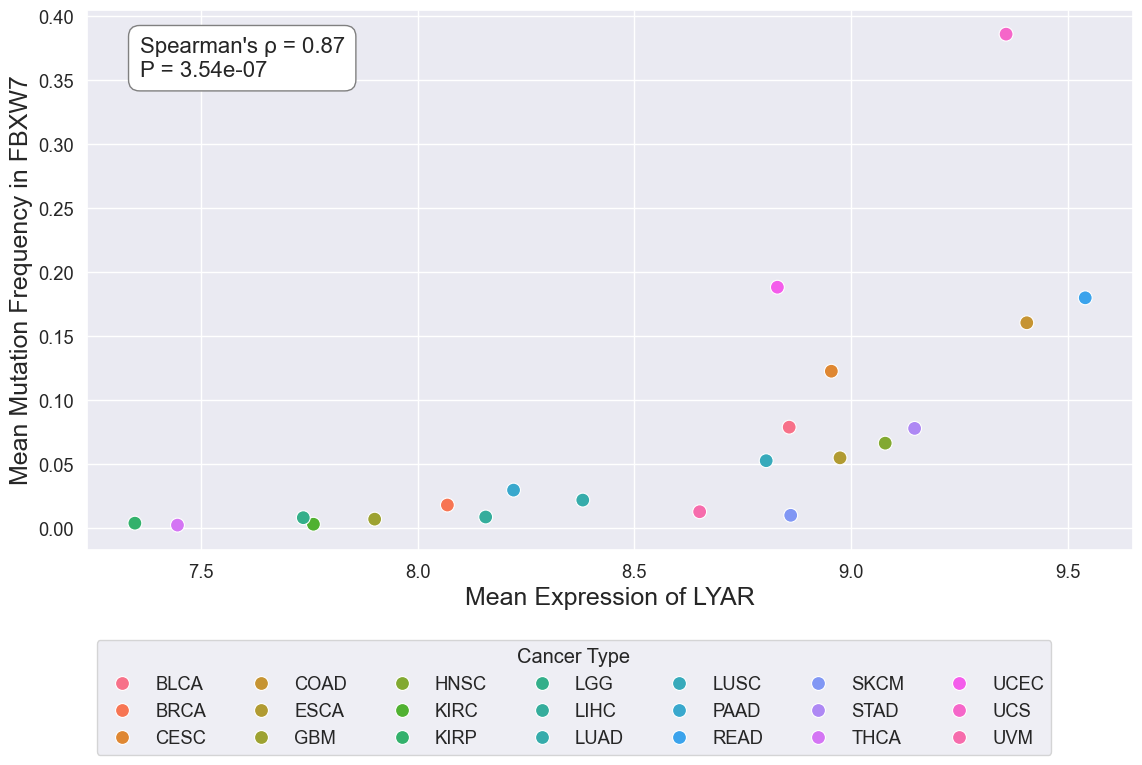

In [42]:
create_spearman_plot('FBXW7', 'LYAR', mutationtab, tumourexp)

## Analysis between Individuals

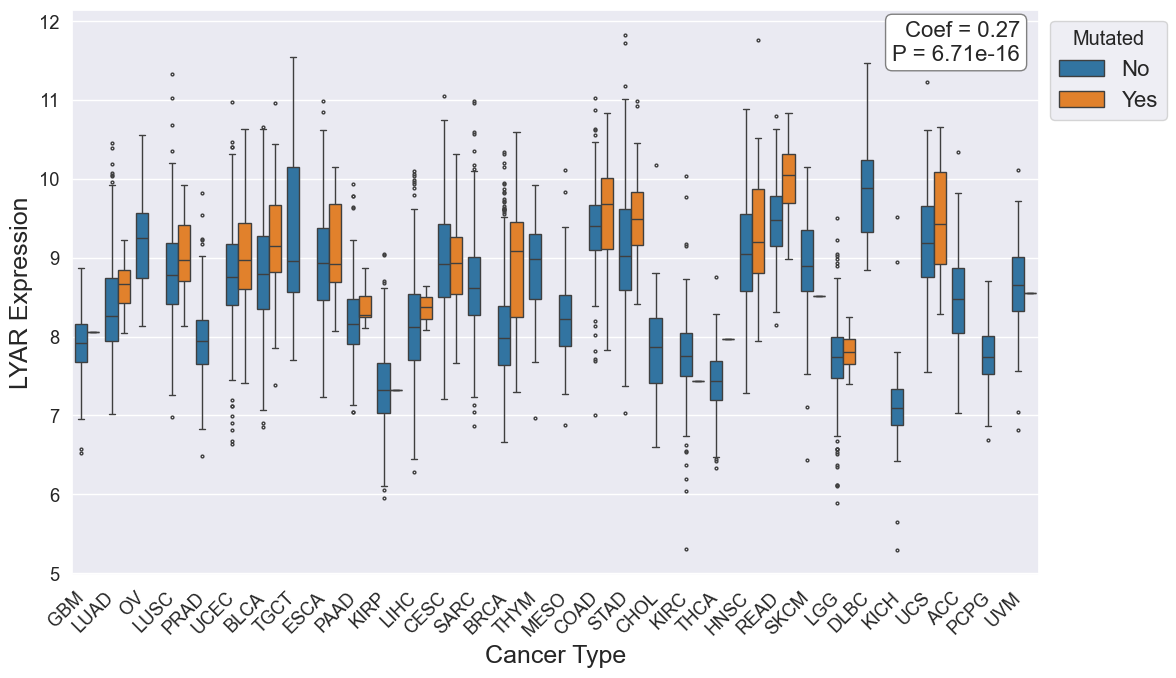

In [46]:
filtered_result = resultsfiltered[(resultsfiltered['driver'] == 'FBXW7') & (resultsfiltered['neighbour'] == 'LYAR')]
coef = filtered_result['coef'].values[0]
p_value = filtered_result['coef_pval'].values[0]
create_ols_boxplots('FBXW7', 'LYAR', coef, p_value, mutationtab, tumourexp)

## Paired Normal-Tumour Samples

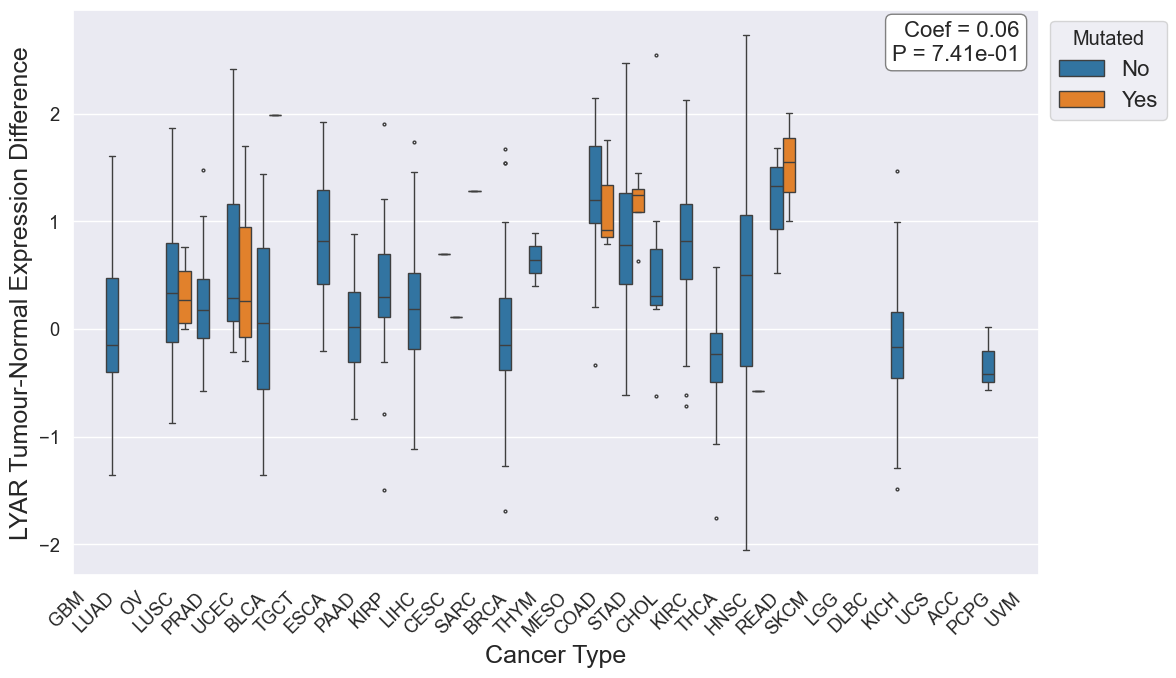

In [55]:
filtered_result = resultsfiltered[(resultsfiltered['driver'] == 'FBXW7') & (resultsfiltered['neighbour'] == 'LYAR')]
coef_diff = filtered_result['coef_diff'].values[0]
p_value_diff = filtered_result['coef_diff_pval'].values[0]
create_ols_boxplots_tumour_normal('FBXW7', 'LYAR', coef_diff, p_value_diff, mutationtab, tumourexp, normalexp)

## Identification of significant DINTs

Within the significant DINTs subset, 10226 interactions exhibited positive correlations, while 3971 interactions exhibited negative correlations. 

In [52]:
# Count for interactions in 'results'
total_sig, total_pos, total_neg = count_significant_interactions(results)
print(total_sig, total_pos, total_neg)  # Total count, positive and negative

filtered_sig, filtered_pos, filtered_neg = count_significant_interactions(resultsfiltered)
print(filtered_sig, filtered_pos, filtered_neg)  # Count after filtering, positive and negative

19609 14075 5534
14197 10226 3971


The FDR analysis revealed that, when using a significance threshold of 0.05, approximately 36.97% of the identified significant interactions could be false positives. Therefore, a further refinement was performed by requiring that each driver gene have at least two significant interactions with neighbours and that each significant neighbour interact with at least two drivers. In this way, the probability that the selected drivers and neighbours do not have any significant interaction is less than 14%.

In [18]:
n_neighbours = results.groupby(["driver"]).size().rename("n_neighbours")
alldints = resultsfiltered[["driver", "neighbour"]].assign(significant=[1]*len(resultsfiltered))
drivers = (
    results[["driver", "neighbour"]]
    # add signal column
    .assign(signal=results.coef/results.coef.abs())
    # add significant column
    .merge(alldints, how="left")
    # fill non significant interactions with 0
    .fillna(0)
    .drop(columns="neighbour")
    # compute number of positive and negative DINTs by driver
    .groupby(["driver", "signal"], as_index=False).sum()
    # add total number of interactions by driver
    .merge(n_neighbours, left_on="driver", right_index=True)
    # calculate percentage of positive and negative DINTs per driver
    .pivot(index=["driver", "n_neighbours"], columns="signal",
           values="significant")
    # fill 0 in drivers that have neighbours with only one signal
    .fillna(0).astype(int)
    .rename(columns={1: "pos_dints", -1: "neg_dints"})
    .reset_index().rename_axis(None, axis=1)
    .assign(
        n_dints=lambda x: x.neg_dints+x.pos_dints,
        neg_pct=lambda x: x.neg_dints/x.n_neighbours,
        pos_pct=lambda x: x.pos_dints/x.n_neighbours,
    )
    .fillna(0)
)
drivers = drivers.assign(group=labeldrivers(drivers))

filt_drivers = drivers.copy()
filt_drivers.loc[(filt_drivers.n_dints == 1), "group"] = "non_sign"
filt_drivers

,driver,n_neighbours,neg_dints,pos_dints,n_dints,neg_pct,pos_pct,group
0,A1CF,39,0,0,0,0.000000,0.000000,non_sign
1,A2ML1,91,3,4,7,0.032967,0.043956,more_pos
2,ABCA10,5,0,0,0,0.000000,0.000000,non_sign
3,ABCA13,9,1,3,4,0.111111,0.333333,more_pos
4,ABCA7,16,0,0,0,0.000000,0.000000,non_sign
...,...,...,...,...,...,...,...,...
2560,ZSWIM3,6,0,0,0,0.000000,0.000000,non_sign
2561,ZSWIM6,22,0,0,0,0.000000,0.000000,non_sign
2562,ZWILCH,22,0,1,1,0.000000,0.045455,non_sign
2563,ZWINT,136,0,22,22,0.000000,0.161765,pos


In [19]:
# List of drivers with a group other than 'non_sign'
significant_drivers_filt = filt_drivers[filt_drivers['group'] != 'non_sign']['driver'].tolist()

# List of drivers with group equal to 'non_sign'
non_significant_drivers_filt = filt_drivers[filt_drivers['group'] == 'non_sign']['driver'].tolist()

print(f"Drivers with a group other than 'non_sign': {len(significant_drivers_filt)}")
print(significant_drivers_filt)

print(f"Drivers with group equal to 'non_sign': {len(non_significant_drivers_filt)}")
print(non_significant_drivers_filt)

Drivers with a group other than 'non_sign': 1271
['A2ML1', 'ABCA13', 'ABCB1', 'ABCC5', 'ABCC9', 'ABCD1', 'ABCF1', 'ABCG2', 'ABI1', 'ABL1', 'ABL2', 'ABLIM2', 'ACAN', 'ACO1', 'ACTB', 'ACTL6B', 'ACVR2A', 'ADAM22', 'ADAMTS12', 'ADAMTS18', 'ADCK1', 'ADCY3', 'ADCY5', 'ADD2', 'ADD3', 'ADNP', 'AFF2', 'AFF3', 'AFF4', 'AGO4', 'AHCTF1', 'AHI1', 'AHNAK', 'AHNAK2', 'AHSA1', 'AJUBA', 'AKAP11', 'AKAP13', 'AKAP6', 'AKAP9', 'AKT1', 'AKT2', 'ALB', 'ALDH5A1', 'ALK', 'ALMS1', 'ALOX12B', 'ALPK2', 'AMER1', 'AMOT', 'AMPH', 'ANK1', 'ANK2', 'ANK3', 'ANKLE2', 'ANKRD12', 'ANKRD17', 'ANKRD26', 'ANKRD36', 'ANKRD50', 'ANLN', 'ANPEP', 'AP1B1', 'AP2A1', 'AP3D1', 'APC', 'API5', 'APLNR', 'APOB', 'APOBEC3B', 'APOBR', 'AR', 'ARAF', 'ARHGAP32', 'ARHGAP35', 'ARHGAP5', 'ARHGEF10', 'ARHGEF10L', 'ARHGEF11', 'ARHGEF12', 'ARHGEF18', 'ARHGEF6', 'ARID1A', 'ARID1B', 'ARID3B', 'ARNT', 'ARNT2', 'ASAP2', 'ASCC2', 'ASCC3', 'ASH1L', 'ASPM', 'ASXL1', 'ASXL2', 'ASXL3', 'ATAD2', 'ATF7IP', 'ATG2A', 'ATM', 'ATP10A', 'ATP10D', 'ATP1A1', 'ATP

In [20]:
significant_drivers = drivers[drivers['group'] != 'non_sign']['driver'].tolist()
non_significant_drivers = drivers[drivers['group'] == 'non_sign']['driver'].tolist()

print(f"Drivers with a group other than 'non_sign': {len(significant_drivers)}")
print(significant_drivers)

print(f"Drivers with group equal to 'non_sign': {len(non_significant_drivers)}")
print(non_significant_drivers)

Drivers with a group other than 'non_sign': 1655
['A2ML1', 'ABCA13', 'ABCB1', 'ABCC3', 'ABCC5', 'ABCC9', 'ABCD1', 'ABCF1', 'ABCG2', 'ABCG8', 'ABI1', 'ABL1', 'ABL2', 'ABLIM2', 'ACAN', 'ACKR3', 'ACO1', 'ACTB', 'ACTL6B', 'ACVR1', 'ACVR1B', 'ACVR2A', 'ADAM10', 'ADAM22', 'ADAM7', 'ADAMTS12', 'ADAMTS18', 'ADAMTS5', 'ADAMTSL3', 'ADCK1', 'ADCY1', 'ADCY3', 'ADCY5', 'ADCY8', 'ADD2', 'ADD3', 'ADNP', 'AFF2', 'AFF3', 'AFF4', 'AGBL2', 'AGGF1', 'AGO4', 'AHCTF1', 'AHCYL2', 'AHI1', 'AHNAK', 'AHNAK2', 'AHSA1', 'AJUBA', 'AKAP11', 'AKAP13', 'AKAP6', 'AKAP9', 'AKT1', 'AKT2', 'ALB', 'ALDH5A1', 'ALDOA', 'ALK', 'ALMS1', 'ALOX12B', 'ALPK1', 'ALPK2', 'AMER1', 'AMOT', 'AMOTL1', 'AMPH', 'ANK1', 'ANK2', 'ANK3', 'ANKLE2', 'ANKRD12', 'ANKRD13A', 'ANKRD17', 'ANKRD26', 'ANKRD36', 'ANKRD50', 'ANLN', 'ANPEP', 'AP1B1', 'AP2A1', 'AP3D1', 'APC', 'API5', 'APLNR', 'APMAP', 'APOB', 'APOBEC3B', 'APOBR', 'AR', 'ARAF', 'ARHGAP26', 'ARHGAP32', 'ARHGAP35', 'ARHGAP5', 'ARHGEF10', 'ARHGEF10L', 'ARHGEF11', 'ARHGEF12', 'ARHGEF18', 'AR

In [21]:
# stats
for label, df in zip(["Unfiltered stats", "Filtered stats"], [drivers, filt_drivers]):
    print(label)
    print("----------------")
    print(f"{'':^11}# DINTs: {df.n_dints.sum()}")
    print(f"{'':^4}# sign drivers: {(df.group != 'non_sign').sum()}")
    print(f"{'':^5}# pos drivers: {(df.group == 'pos').sum()}")
    print(f"{'':^5}# neg drivers: {(df.group == 'neg').sum()}")
    print(f"{'':^0}# more pos drivers: {(df.group == 'more_pos').sum()}")
    print(f"{'':^0}# more neg drivers: {(df.group == 'more_neg').sum()}")
    print(f"{'':^1}# neutral drivers: {(df.group == 'neutral').sum()}")
    print(f"{'':^1}# nonsign drivers: {(df.group == 'non_sign').sum()}")
    print()

# The significant DINTs interactions involved 1655 driver genes.

Unfiltered stats
----------------
           # DINTs: 14197
    # sign drivers: 1655
     # pos drivers: 489
     # neg drivers: 254
# more pos drivers: 576
# more neg drivers: 185
 # neutral drivers: 151
 # nonsign drivers: 910

Filtered stats
----------------
           # DINTs: 14197
    # sign drivers: 1271
     # pos drivers: 274
     # neg drivers: 85
# more pos drivers: 576
# more neg drivers: 185
 # neutral drivers: 151
 # nonsign drivers: 1294



In [22]:
meanexp = tumourexp.reset_index(drop=True).median().rename("expression")
meanexp.head()

A1BG       6.25
A1CF       0.00
A2M       13.21
A2ML1      2.39
A4GALT     8.67
Name: expression, dtype: float64

In [23]:
n_inters = results.groupby(["neighbour"]).size().rename("n_inters")
alldints = resultsfiltered[["driver", "neighbour"]].assign(significant=[1]*len(resultsfiltered))
neighbours = (
    results[["driver", "neighbour"]]
    # add signal column
    .assign(signal=results.coef/results.coef.abs())
    # add significant column
    .merge(alldints, how="left")
    # fill non significant interactions with 0
    .fillna(0)
    .drop(columns="driver")
    # compute number of positive and negative DINTs by neighbour
    .groupby(["neighbour", "signal"], as_index=False).sum()
    # add total number of interactions by driver
    .merge(n_inters, left_on="neighbour", right_index=True)
    # calculate percentage of positive and negative DINTs per neighbour
    .pivot(index=["neighbour", "n_inters"], columns="signal",
           values="significant")
    # fill 0 in neighbours that have DINTs with only one signal
    .fillna(0).astype(int)
    .rename(columns={1: "pos_dints", -1: "neg_dints"})
    .reset_index().rename_axis(None, axis=1)
    .assign(
        n_dints=lambda x: x.neg_dints+x.pos_dints,
    )
)

neighbours = (
    neighbours
    .assign(group=labelneighbours(neighbours))
    .merge(meanexp, how="left", left_on="neighbour", right_index=True)
)

filt_neighbours = neighbours.copy()
filt_neighbours.loc[(filt_neighbours.n_dints == 1), "group"] = "non_sign"
filt_neighbours

,neighbour,n_inters,neg_dints,pos_dints,n_dints,group,expression
0,A1BG,13,0,0,0,non_sign,6.25
1,A2M,51,1,0,1,non_sign,13.21
2,A2ML1,18,0,0,0,non_sign,2.39
3,A4GALT,3,0,0,0,non_sign,8.67
4,AAAS,49,0,0,0,non_sign,9.63
...,...,...,...,...,...,...,...
13059,ZYG11A,3,0,0,0,non_sign,3.75
13060,ZYG11B,14,0,0,0,non_sign,9.69
13061,ZYX,109,0,0,0,non_sign,11.93
13062,ZZEF1,15,0,0,0,non_sign,10.19


In [24]:
# List of neighbours with a group other than 'non_sign'
significant_neighbours = neighbours[neighbours['group'] != 'non_sign']['neighbour'].tolist()

# List of neighbours with group equal to 'non_sign'
non_significant_neighbours = neighbours[neighbours['group'] == 'non_sign']['neighbour'].tolist()

print(f"Neighbours with a group other than 'non_sign': {len(significant_neighbours)}")
print(significant_neighbours)

print(f"Neighbours with group equal to 'non_sign': {len(non_significant_neighbours)}")
print(non_significant_neighbours)

Neighbours with a group other than 'non_sign': 3120
['A2M', 'AAGAB', 'AAK1', 'AASS', 'ABCA1', 'ABCA2', 'ABCD1', 'ABCE1', 'ABCF1', 'ABCF2', 'ABCG2', 'ABHD12', 'ABI2', 'ABL2', 'ABLIM3', 'ABT1', 'ACACA', 'ACACB', 'ACAD10', 'ACAD11', 'ACBD3', 'ACCS', 'ACOT7', 'ACP1', 'ACSS3', 'ACTB', 'ACTG1', 'ACTL6A', 'ACTN2', 'ACTN4', 'ACTR10', 'ACTR2', 'ACTR3', 'ACTR5', 'ADAM9', 'ADAMTS1', 'ADAMTS10', 'ADAMTS13', 'ADARB1', 'ADCY2', 'ADCY9', 'ADD1', 'ADD2', 'ADRA1D', 'ADRB2', 'AEN', 'AFF3', 'AGAP11', 'AGAP3', 'AGBL4', 'AGMAT', 'AGR2', 'AGT', 'AGTR1', 'AHCTF1', 'AHCY', 'AHNAK', 'AHR', 'AHSA1', 'AIF1', 'AIM2', 'AIMP1', 'AIMP2', 'AK2', 'AKAP11', 'AKAP9', 'AKR7A3', 'AKT3', 'AKTIP', 'ALAS1', 'ALB', 'ALDH18A1', 'ALDH1L1', 'ALDH9A1', 'ALDOA', 'ALG11', 'ALKBH3', 'AMIGO1', 'AMOT', 'AMOTL1', 'AMOTL2', 'AMPH', 'AMY2B', 'ANAPC1', 'ANAPC10', 'ANK2', 'ANK3', 'ANKAR', 'ANKFY1', 'ANKH', 'ANKRA2', 'ANKRD13A', 'ANKRD39', 'ANKRD52', 'ANKRD6', 'ANKS1B', 'ANKS6', 'ANLN', 'ANO5', 'ANP32A', 'ANP32B', 'ANP32E', 'ANXA1', 'ANXA2'

In [25]:
# List of neighbours with a group other than ‘non_sign’
significant_neighbours_filt = filt_neighbours[filt_neighbours['group'] != 'non_sign']['neighbour'].tolist()

# List of neighbours with group equal to 'non_sign'
non_significant_neighbours_filt = filt_neighbours[filt_neighbours['group'] == 'non_sign']['neighbour'].tolist()

print(f"Neighbours with a group other than 'non_sign': {len(significant_neighbours_filt)}")
print(significant_neighbours_filt)

print(f"Neighbours with group equal to 'non_sign': {len(non_significant_neighbours_filt)}")
print(non_significant_neighbours_filt)

Neighbours with a group other than 'non_sign': 1614
['ABCE1', 'ABCF2', 'ABCG2', 'ABLIM3', 'ABT1', 'ACACB', 'ACAD11', 'ACOT7', 'ACTB', 'ACTG1', 'ACTL6A', 'ACTN2', 'ACTR2', 'ACTR3', 'ACTR5', 'ADAMTS1', 'ADAMTS13', 'ADARB1', 'ADCY9', 'ADD1', 'ADRB2', 'AGAP11', 'AGBL4', 'AGR2', 'AGT', 'AGTR1', 'AHCTF1', 'AHSA1', 'AIM2', 'AIMP2', 'AKT3', 'ALAS1', 'ALB', 'ALDH18A1', 'AMOT', 'AMOTL1', 'ANAPC1', 'ANK2', 'ANK3', 'ANKRD6', 'ANKS1B', 'ANLN', 'ANP32B', 'ANXA1', 'ANXA2', 'AP2A2', 'AP3B2', 'APBA1', 'APBB1', 'APH1B', 'APLP2', 'APOB', 'APP', 'AQP1', 'AQP4', 'AR', 'ARHGAP11A', 'ARHGAP11B', 'ARHGAP24', 'ARHGEF17', 'ARHGEF9', 'ARID3A', 'ARMC7', 'ARPC3', 'ARPC5L', 'ARSG', 'ASAP3', 'ASF1B', 'ASNS', 'ASPM', 'ATAD3A', 'ATAD3B', 'ATG2B', 'ATG5', 'ATIC', 'ATL1', 'ATM', 'ATP1A2', 'ATP1B2', 'ATP1B3', 'ATP2B2', 'ATP8A2', 'ATXN1', 'AURKA', 'AURKAIP1', 'AURKB', 'AXL', 'BACE1', 'BAIAP2L1', 'BAK1', 'BBS1', 'BCAS3', 'BCL2', 'BCL6', 'BECN1', 'BEND3', 'BEX1', 'BIN1', 'BIRC5', 'BLM', 'BMI1', 'BMPR2', 'BMS1', 'BRCA1', 'BR

In [26]:
# stats
for label, df in zip(["Unfiltered stats", "Filtered stats"], [neighbours, filt_neighbours]):
    print(label)
    print("----------------")
    print(f"{'':^13}# DINTs: {df.n_dints.sum()}")
    print(f"{'':^3}# sign neighbours: {(df.group != 'non_sign').sum()}")
    print(f"{'':^4}# pos neighbours: {(df.group == 'pos').sum()}")
    print(f"{'':^4}# neg neighbours: {(df.group == 'neg').sum()}")
    print(f"{'':^0}# neutral neighbours: {(df.group == 'neutral').sum()}")
    print(f"{'':^0}# nonsign neighbours: {(df.group == 'non_sign').sum()}")
    print()

# The significant DINTs interactions involved 3120 significant neighbouring proteins.

Unfiltered stats
----------------
             # DINTs: 14197
   # sign neighbours: 3120
    # pos neighbours: 1727
    # neg neighbours: 1378
# neutral neighbours: 15
# nonsign neighbours: 9944

Filtered stats
----------------
             # DINTs: 14197
   # sign neighbours: 1614
    # pos neighbours: 1013
    # neg neighbours: 586
# neutral neighbours: 15
# nonsign neighbours: 11450



The additional filtering resulted in a final dataset of 1271 significant driver genes and 1614 significant neighbours.

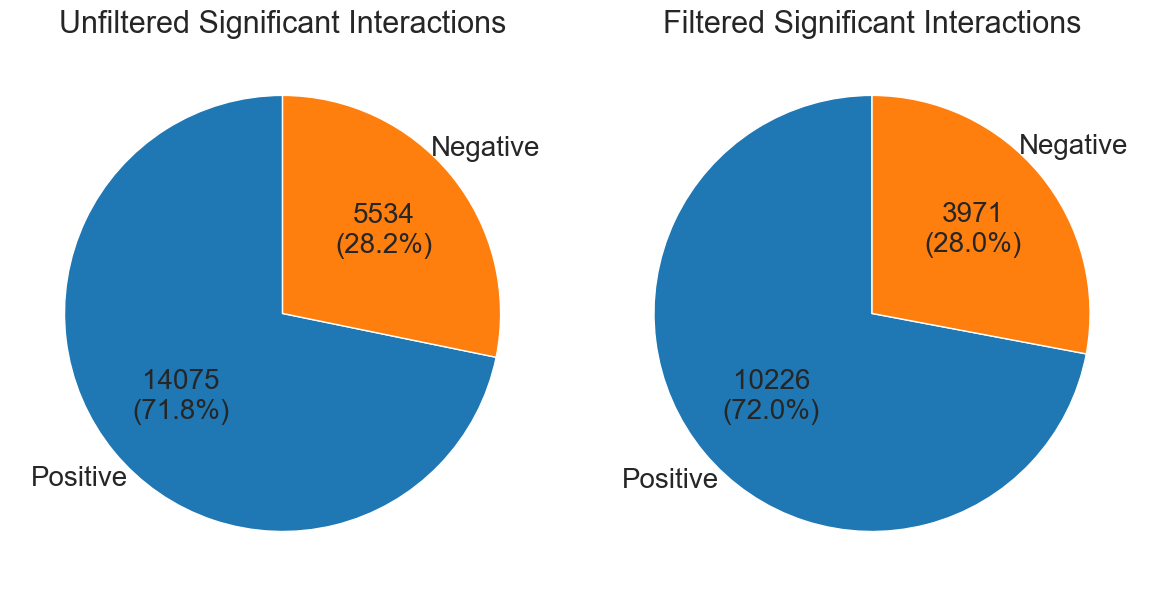

In [50]:
# Data for pie charts
labels = ['Positive', 'Negative']
sizes_unfiltered = [total_pos, total_neg]  # Replace with actual values
sizes_filtered = [filtered_pos, filtered_neg]  # Replace with actual values

# Colours for pie charts
colors = ['#1f77b4', '#ff7f0e']  # Colour scheme consistent with boxplot

# Create figure and subplots for two pie charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Increase font size for labels using textprops
textprops = {"fontsize": 20, "ha": "center", "va": "center"}

# Unfiltered significant interactions pie chart
ax1.pie(sizes_unfiltered, labels=labels, autopct=autopct_format(sizes_unfiltered),
        startangle=90, colors=colors, textprops=textprops, labeldistance=1.20)
ax1.set_title('Unfiltered Significant Interactions', fontsize=22)

# Filtered significant interactions pie chart
ax2.pie(sizes_filtered, labels=labels, autopct=autopct_format(sizes_filtered),
        startangle=90, colors=colors, textprops=textprops, labeldistance=1.20)
ax2.set_title('Filtered Significant Interactions', fontsize=22)

# Adjust layout and display
plt.tight_layout()
plt.show()


Initially, we started with 361705 potential interactions, out of which 19609 were identified as significant based on two criteria: both the correlation and OLS p-values had to be less than 0.05, and the correlation and OLS signals had to be consistent. Of these 19609 significant interactions, 71.8% (14075) were positive, while 28.2% (5534) were negative. After applying the final filtering criterion—where paired tumour-normal analysis was used to remove reverse causation cases—the number of significant interactions decreased to 14197, with 72.0% (10226) being positive and 28.0% (3971) being negative.